In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from kid_readout.measurement.io import npy
from kid_readout.measurement import basic, plot_basic
from kid_readout.analysis.timeseries import filters

In [2]:
npd = npy.NumpyDirectory('/data/readout/2017-11-28_171837_hwp.npd/')

In [3]:
print(npd.metadata.script_code)

"""
Measure resonators, one at a time, with the readout tone centered in the filterbank bin.
"""
from __future__ import division
import time


import numpy as np

from kid_readout.roach import analog, calculate, hardware_tools, tools
from kid_readout.measurement import acquire, basic
from kid_readout.equipment import hardware, starcryo_temps
from equipment.srs import lockin
from equipment.custom import mmwave_source
from xystage import stepper
from kid_readout.settings import LOCKIN_SERIAL_PORT, CRYOGENIC_HWP_MOTOR_SERIAL_PORT

acquire.show_settings()
acquire.show_git_status()
logger = acquire.get_script_logger(__file__)

# Parameters
suffix = 'hwp'
attenuations = [10]
"""
f_center = 1e6 * np.array([
    2757.5,
    2778.3,
    2792.0,
    2816.0,
    2872.0,  # low Q
    2921.5,
    2998.5,
    3001.0,
    3085.0,
    3229.0, # done
    3316.5,
    3347.0,
    3370.5,
    3420.5,
    3922.0  # no-man's land
    ])
"""
f_center = 1e6 * np.array([3420.5])
fractional_frequency_shift = 0


In [4]:
npd.node_names()

['SingleSweep0', 'SingleSweepStreamList1', 'ADCSnap2']

In [5]:
coarse = npd.SingleSweep0
sssl = npd.SingleSweepStreamList1
snap = npd.ADCSnap2

# ADCSnap

In [6]:
snap.x.ptp(), snap.y.ptp()

(32.0, 33.0)

# Coarse sweep

In [7]:
1e-6 * coarse.resonator.f_0

3420.6329717059552

In [8]:
coarse.resonator.Q_e

(67997.922272132288+32354.44771216996j)

In [9]:
coarse.resonator.Q_i

15641.511781901618

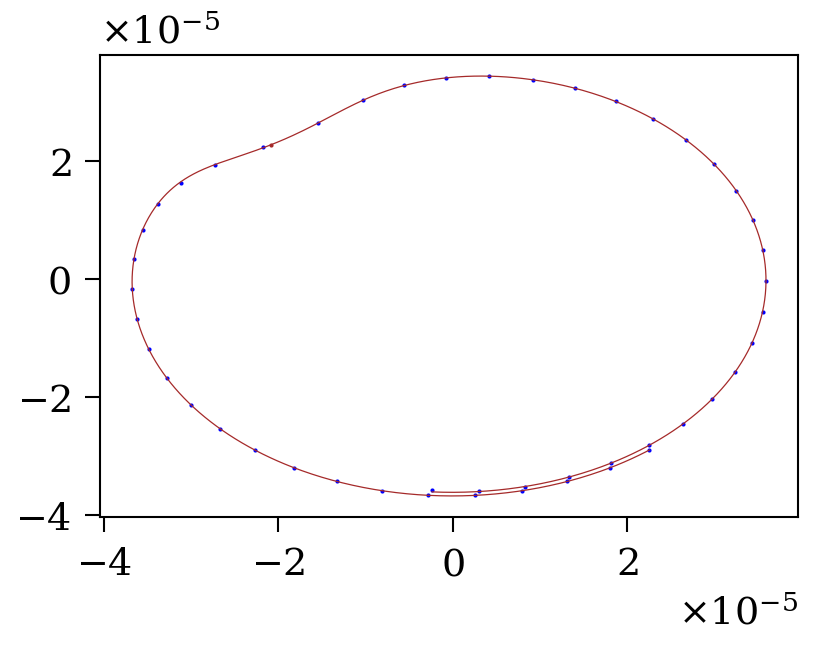

In [10]:
fig, ax = plt.subplots()
plot_basic.resonator_complex_plane(resonator=coarse.resonator, axis=ax, normalize=False);

# Temperatures

In [13]:
s = sssl.stream_list[0]

In [14]:
s.state.temperature

StateDict({u'eccosorb_diode_temperature': 3.29, u'stepper_diode_temperature': 4.684, u'stepper_diode_voltage': 1.609192, u'unix_time': 1511907609.35, u'package_ruox4550_temperature': 0.1988352, u'eccosorb_diode_voltage': 1.617462, u'date_and_time': u'20171128-172009', u'package_ruox4550_resistance': 7872.296})

In [15]:
package_color = 'C0'
eccosorb_color = 'C1'
stepper_color = 'C2'

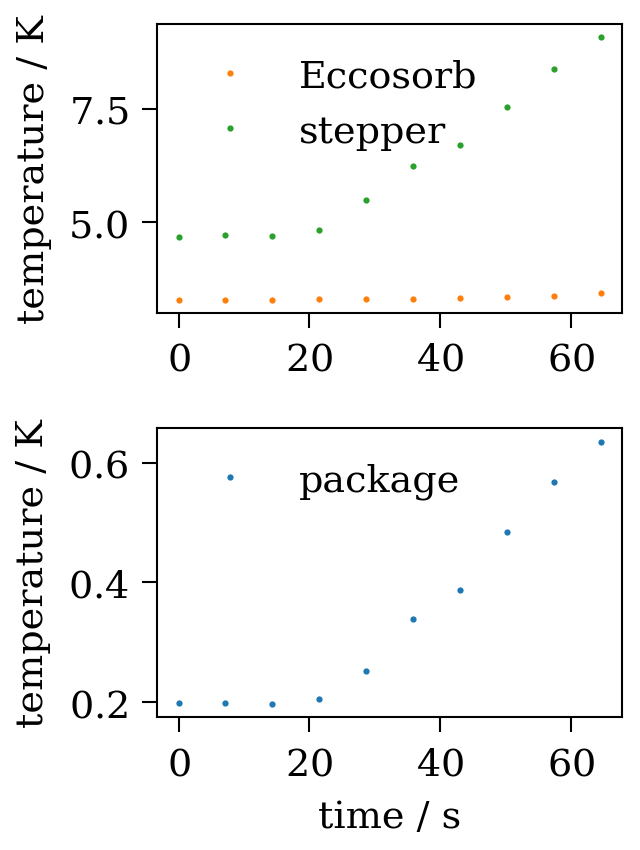

In [25]:
fig, (other_ax, package_ax) = plt.subplots(2, 1, figsize=(2, 3), gridspec_kw={'hspace': 0.4})
other_ax.set_ylabel('temperature / K')
package_ax.set_ylabel('temperature / K')
package_ax.set_xlabel('time / s')

time = [stream.epoch - sssl.stream_list[0].epoch for stream in sssl.stream_list]
package = [stream.state.temperature.package_ruox4550_temperature for stream in sssl.stream_list]
eccosorb = [stream.state.temperature.eccosorb_diode_temperature for stream in sssl.stream_list]
stepper = [stream.state.temperature.stepper_diode_temperature for stream in sssl.stream_list]

package_ax.plot(time, package, '.', color=package_color, label='package')
other_ax.plot(time, eccosorb, '.', color=eccosorb_color, label='Eccosorb')
other_ax.plot(time, stepper, '.', color=stepper_color, label='stepper')

package_ax.legend()
other_ax.legend()

# Lock-in voltage

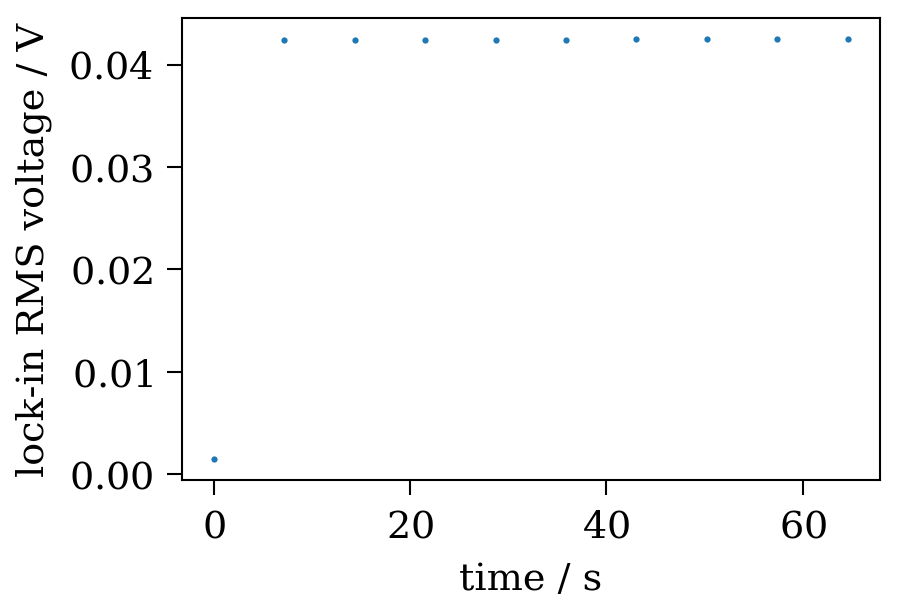

In [58]:
time = [stream.epoch - sssl.stream_list[0].epoch for stream in sssl.stream_list]
voltage = [stream.state.lockin.rms_voltage for stream in sssl.stream_list]

fig, ax = plt.subplots()
ax.set_xlabel('time / s')
ax.set_ylabel('lock-in RMS voltage / V')
ax.plot(time, voltage, '.')

# Fine sweep

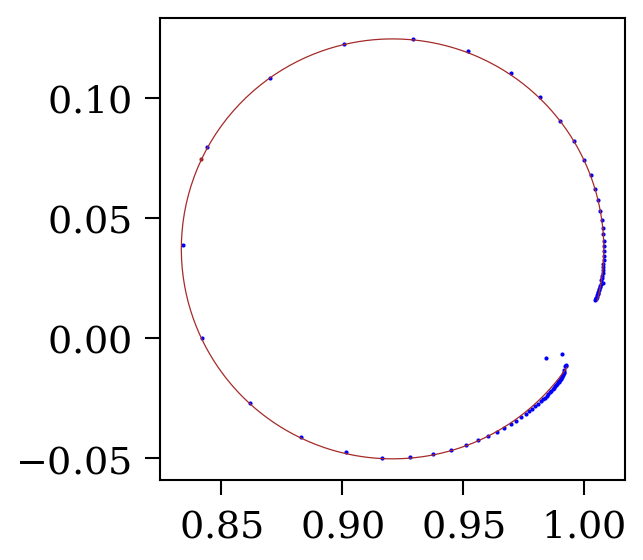

In [26]:
fig, ax = plt.subplots(figsize=(2, 2))
plot_basic.resonator_complex_plane(resonator=sssl.resonator, axis=ax, normalize=True);

# Streams

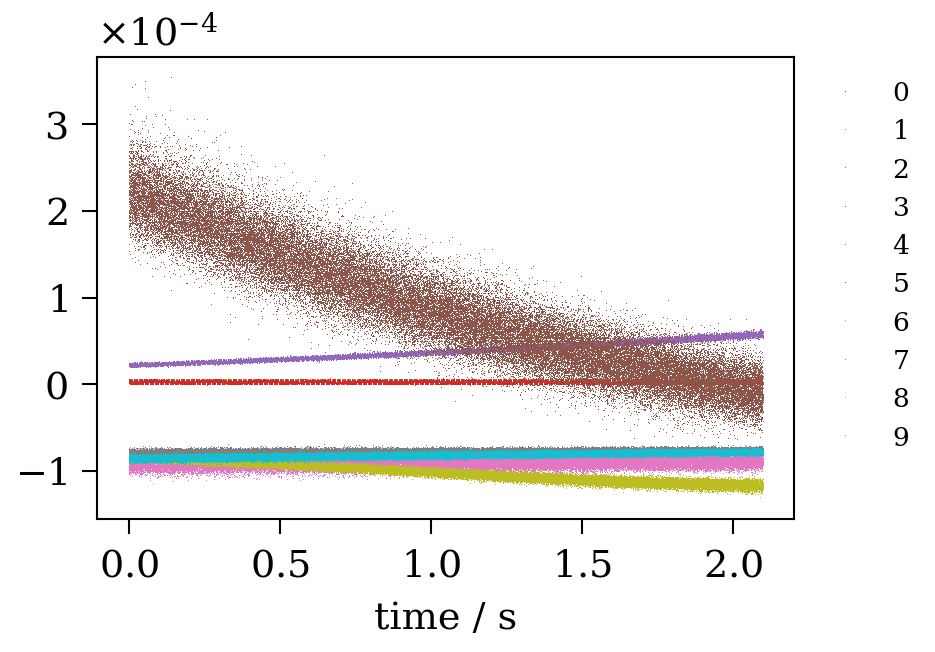

In [40]:
fig, ax = plt.subplots()
ax.set_xlabel('time / s')
for index, stream in enumerate(sssl.stream_list):
    x, q = sssl.x_and_q(index)
    ax.plot(stream.sample_time, x, ',', label=str(index))
    #ax.plot(stream.sample_time, q, ',', label='$Q_i^{-1}$')
ax.legend(fontsize='xx-small', bbox_to_anchor=(1, 1))

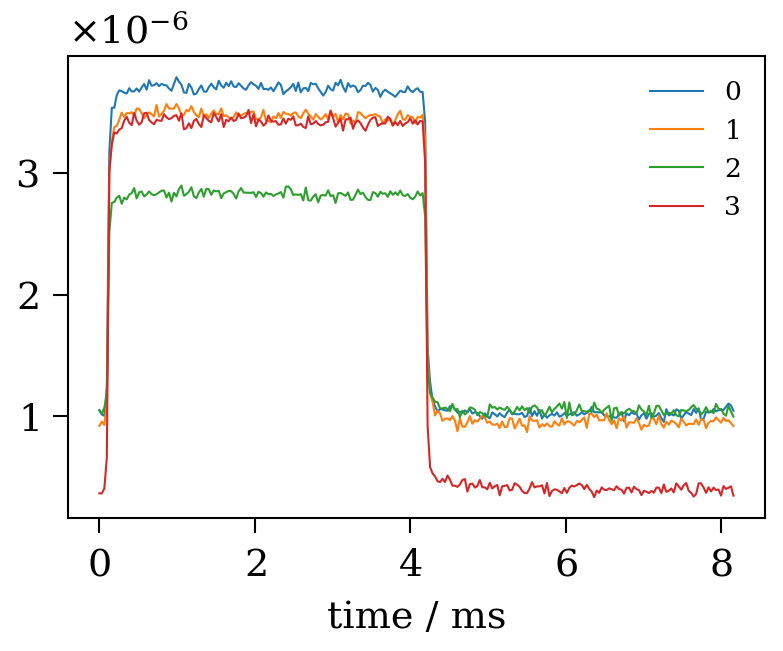

In [41]:
fig, ax = plt.subplots()
ax.set_xlabel('time / ms')
for index, stream in enumerate(sssl.stream_list[:4]):
    x, q = sssl.x_and_q(index)
    x_fold = stream.fold(x)
    ax.plot(1e3 * np.arange(x_fold.size) / stream.stream_sample_rate, x_fold, '-', label=str(index))
ax.legend(fontsize='xx-small', bbox_to_anchor=(1, 1));

In [42]:
def decimate(sss, num_taps=256, downsample=8):
    f_nyquist = sss.stream.stream_sample_rate / 2
    x_lpf = filters.low_pass_fir(sss.x, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    q_lpf = filters.low_pass_fir(sss.q, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    t = sss.stream.sample_time[::downsample]
    size = min(t.size, x_lpf.size)
    return t[:size], x_lpf[:size], q_lpf[:size]

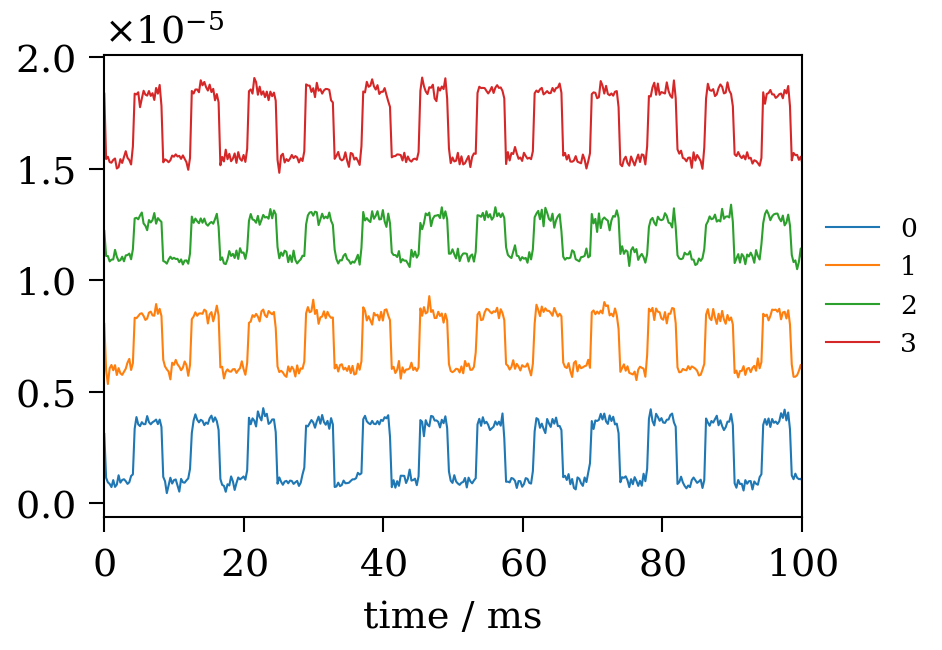

In [53]:
fig, ax = plt.subplots()
ax.set_xlabel('time / ms')
for index, stream in enumerate(sssl.stream_list[:4]):
    sss = basic.SingleSweepStream(sweep=sssl.single_sweep, stream=stream)
    t_lpf, x_lpf, q_lpf = decimate(sss)
    ax.plot(1e3 * t_lpf, 5e-6 * index + x_lpf, '-', label=str(index))
ax.legend(fontsize='xx-small', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlim(0, 100);